In [1]:
!python -m pip install -e . >> /dev/null

In [2]:
import toolviper
import xradio
import pathlib
import numba

import numpy as np
import pandas as pd
import calviper as cv
import matplotlib.pyplot as plt

from xradio import measurement_set as ms

In [3]:
if not pathlib.Path.cwd().joinpath("data/gaincaltest2.ps.zarr").exists():
    toolviper.utils.data.download("gaincal.test.zarr", "data")

In [4]:
ps = ms.open_processing_set("data/gaincaltest2.ps.zarr")

sub_ps = ps.sel(intents="CALIBRATE_DELAY#ON_SOURCE", scan_number=2)
sub_ps.summary()

,name,intents,shape,polarization,scan_number,spw_name,field_name,source_name,line_name,field_coords,start_frequency,end_frequency
1,gaincaltest2_0,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(957, 45, 8, 4)","[XX, XY, YX, YY]","[2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26]",X0000000000#ALMA_RB_03#BB_1#SW-01#FULL_RES_0,[J2255-3500_0],[J2255-3500_0],[],"[icrs, 22h55m57.68s, -35d00m00.00s]",8.607155e+10,8.629030e+10
0,gaincaltest2_2,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(957, 45, 8, 4)","[XX, XY, YX, YY]","[2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26]",X0000000000#ALMA_RB_03#BB_2#SW-01#FULL_RES_1,[J2255-3500_0],[J2255-3500_0],[],"[icrs, 22h55m57.68s, -35d00m00.00s]",8.794655e+10,8.816530e+10
3,gaincaltest2_4,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(957, 45, 8, 4)","[XX, XY, YX, YY]","[2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26]",X0000000000#ALMA_RB_03#BB_3#SW-01#FULL_RES_2,[J2255-3500_0],[J2255-3500_0],[],"[icrs, 22h55m57.68s, -35d00m00.00s]",9.632156e+10,9.654030e+10
2,gaincaltest2_6,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(957, 45, 8, 4)","[XX, XY, YX, YY]","[2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26]",X0000000000#ALMA_RB_03#BB_4#SW-01#FULL_RES_3,[J2255-3500_0],[J2255-3500_0],[],"[icrs, 22h55m57.68s, -35d00m00.00s]",9.819656e+10,9.841530e+10


In [5]:
dataset = sub_ps["gaincaltest2_0"]

In [6]:
V = dataset.VISIBILITY.mean(dim="time").data.compute()

In [7]:
s = dataset.VISIBILITY.shape
s

(957, 45, 8, 4)

In [8]:
gain_jones = cv.jones.GainJones()

In [9]:
G = gain_jones.from_visibility(dataset=dataset)

In [10]:
G.matrix.shape

(957, 45, 8, 2, 2)

In [11]:
G.parameters.shape

(957, 8, 36)

In [12]:
g = G.matrix.mean(axis=0)
g.shape

(45, 8, 2, 2)

In [13]:
# This should all be done within the equivelent of VisEquation
v = V[:, 0, 0]

index_a, ant = cv.math.tools.encode(dataset.baseline_antenna1_name.to_numpy())
index_b, _ = cv.math.tools.encode(dataset.baseline_antenna2_name.to_numpy())

v_ = cv.math.tools.build_visibility_matrix(array=v, index_a=index_a, index_b=index_b)

In [14]:
v_.shape

(9, 9)

In [15]:
solver = cv.math.solver.least_squares.LeastSquaresSolver()

In [16]:
gain_solutions = solver.solve(
    vis=v_,
    iterations=40,
    optimizer=cv.math.optimizer.MeanSquaredError(alpha=0.2),
    stopping=1e-4
)

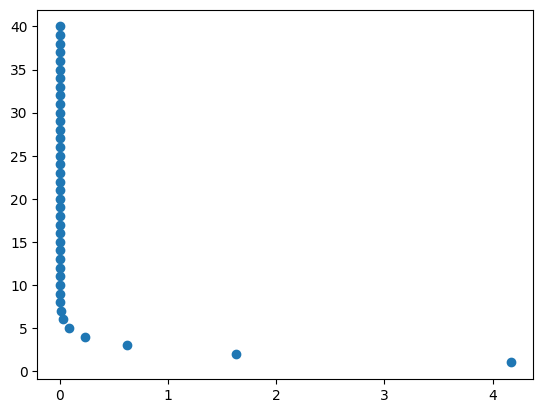

In [17]:
t = np.linspace(1, len(solver.losses), len(solver.losses))

plt.scatter(solver.losses, t)

In [18]:
# Gain solutions

solver.parameter

array([0.98435739-0.07941222j, 0.97513866-0.07647791j,
       0.93544834-0.20615898j, 0.93922148-0.04046039j,
       0.88351005-0.11470297j, 0.88874281+0.00357627j,
       0.87630051+0.07383113j, 0.85103414+0.15219365j,
       0.81860585+0.27813677j])

In [19]:
G.matrix.shape

(957, 45, 8, 2, 2)

In [20]:
solver.parameter.shape

(9,)

In [ ]:
G.matrix = G.matrix * solver.parameter

In [ ]:
G_inv = np.linalg.inv(G.matrix)
G_inv_H = np.linalg.inv(G.matrix.conj().T)

In [ ]:
cache = np.matmul(V, G_inv_H)

In [ ]:
T = np.matmul(G_inv, cache)

In [ ]:
fig, ax = plt.subplots()

rl = ax.imshow(T.real)
plt.colorbar(rl)

In [ ]:
fig, ax = plt.subplots()

im = ax.imshow(T.imag)
plt.colorbar(im)

In [ ]:
P = np.array([[[1, 2, 3, 4], [5, 6, 7, 8]]])

In [ ]:
l = P.flatten().shape[0]

np.identity(l)*P.flatten()

In [ ]:
M = np.array(
    [
        [1, 2],
        [3, 4],
        [5, 6]
    ]
)

In [ ]:
M.flatten()